# Задача 2: Экспоненциальное сглаживание и прогноз

В работе исследуется применение алгоритма экспоненциального сглаживания к прогнозированию временных рядов. В основе алгоритма лежит учет предыдущих значений ряда с весами, убывающими по мере удаления от исследуемого участка временного ряда. Изучено поведение алгоритма на модельных данных в различных моделях весов. Проведен анализ работы алгоритма на реальных данных -– биржевых индексах.

# Описание

Метод, известный также как метод Брауна, выглядит следующим образом. По первым членам временного ряда $\{x_{t}\}$ проводится аппроксимация, с помощью которой прогнозируются следующие $N$ членов ряда. Для этого строится ряд экспоненциальных средних $\{S_{t}\}$, строящийся рекурсионно на основе прошлых значений ряда $S$:
$$S_{t} = \alpha x_{t} + (1 - \alpha)S_{t - 1}, \quad t > 1.$$
Начальное значение $S_0$ обычно принимается равным начальному элементу исходного временного ряда, а параметр сглаживания $\alpha$ находится в диапазоне $(0,1)$. От его выбора зависит достижение наилучшего качества модели. Чем он меньше, тем больше фильтруются колебания и выбросы исходного ряда. В то же повышение коэффициента приводит к увеличению значимости последних членов исходного ряда (увеличение весов), что может быть важно для прогнозирования небольшого окна. Поиск такого компромисса - зачастую суть задачи.

Для наглядности формулу для $S_{t}$ можно переписать в виде суммы, зависящий от начального элемента $S_{0}$ и элементов исходного ряда $\{x_{t}\}$:
$$S_{t} = \alpha \sum\limits_{i = 0}^{t-1}(1 - \alpha)^{i} x_{t - i} + (1 - \alpha)^{t}S_{0}$$

# Практическая часть

В качестве данных будем использовать биржевые котировки. Для их получения понадобятся специфическая библиотека Yahoo Finance

In [15]:
import yfinance as yf
import pandas_datareader.data as pdr
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

yf.pdr_override()
%matplotlib inline

Пример использования этой библиотеки для получения истории котировок Боинга за 2018 год

In [59]:
all_data = pdr.get_data_yahoo("BA", "2018-01-01", "2019-01-01")
print(all_data)

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2018-01-02  295.750000  296.989990  295.399994  296.839996  282.886383   
2018-01-03  295.940002  298.500000  295.470001  297.799988  283.801239   
2018-01-04  297.940002  298.420013  295.470001  296.670013  282.724396   
2018-01-05  296.769989  308.890015  296.720001  308.839996  294.322296   
2018-01-08  308.660004  310.859985  305.750000  310.149994  295.570740   
...                ...         ...         ...         ...         ...   
2018-12-24  300.649994  303.000000  294.160004  294.160004  285.834320   
2018-12-26  298.609985  314.089996  292.470001  313.929993  305.044769   
2018-12-27  309.040009  317.140015  302.239990  317.140015  308.163910   
2018-12-28  319.739990  321.529999  315.149994  316.380005  307.425446   
2018-12-31  320.500000  323.640015  318.750

Для заполнения временного ряда будем использовать только цены открытия

In [60]:
def get_stock_data(ticker, start_date, end_date):
    all_data = pdr.get_data_yahoo(ticker, start_date, end_date)
    open_price = all_data["Open"]
    return open_price

In [61]:
open_price = get_stock_data("BA", "2018-01-01", "2019-01-01")
open_price 

[*********************100%***********************]  1 of 1 completed


Date
2018-01-02    295.750000
2018-01-03    295.940002
2018-01-04    297.940002
2018-01-05    296.769989
2018-01-08    308.660004
                 ...    
2018-12-24    300.649994
2018-12-26    298.609985
2018-12-27    309.040009
2018-12-28    319.739990
2018-12-31    320.500000
Name: Open, Length: 251, dtype: float64

In [62]:
open_price.values

array([295.75      , 295.94000244, 297.94000244, 296.76998901,
       308.66000366, 310.58999634, 317.48999023, 322.13000488,
       330.38000488, 339.8999939 , 337.73001099, 350.70001221,
       341.67001343, 335.29000854, 338.33999634, 336.20001221,
       336.20999146, 344.32998657, 341.23001099, 339.17001343,
       360.5       , 352.95001221, 354.        , 342.67001343,
       320.        , 340.51998901, 348.        , 333.54998779,
       336.57000732, 340.45001221, 341.33999634, 348.47000122,
       356.58999634, 352.        , 352.55999756, 354.6499939 ,
       358.17999268, 359.5       , 364.6000061 , 366.79998779,
       362.32998657, 341.82000732, 338.        , 354.23999023,
       341.51998901, 349.51000977, 352.6499939 , 355.20001221,
       345.32000732, 339.79000854, 332.29998779, 329.82000732,
       327.45001221, 331.83999634, 337.07000732, 330.10998535,
       320.1499939 , 330.48001099, 331.51000977, 321.8500061 ,
       323.38000488, 325.20001221, 324.76000977, 312.29

Изобразим на графике полученные значения

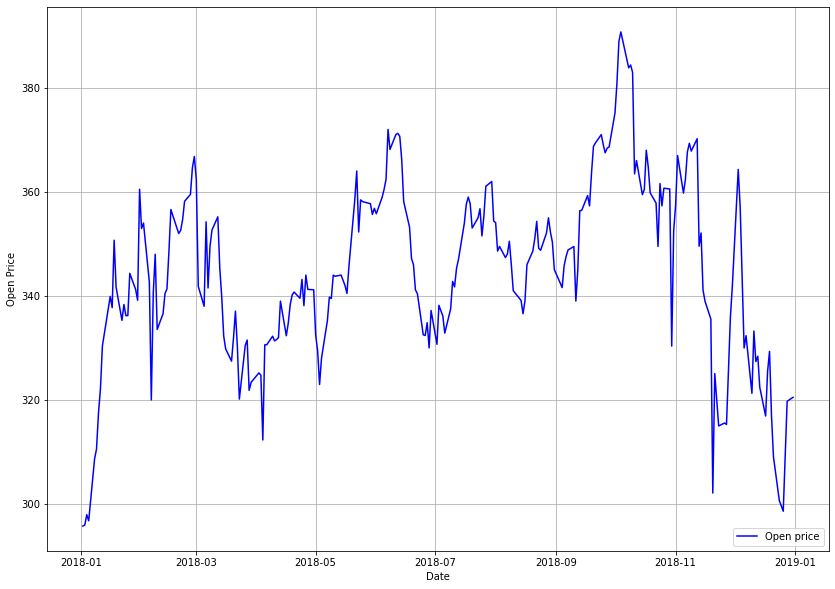

In [104]:
plt.figure(figsize=(14, 10))
plt.plot(open_price, 'b', label = 'Open price')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend(loc = 'lower right')
plt.grid(True)
plt.show()

Теперь задача - сделать сглаживание этого ряда

In [105]:
def exp_smooth(x, alpha, lenght):
    s = [x[0]]
    for i in range(1, lenght):
        s.append(round(alpha * x[i] + (1 - alpha) * s[i-1]))
    return s

Проведем несколько опытов для разных значений $\alpha$ и длины ряда

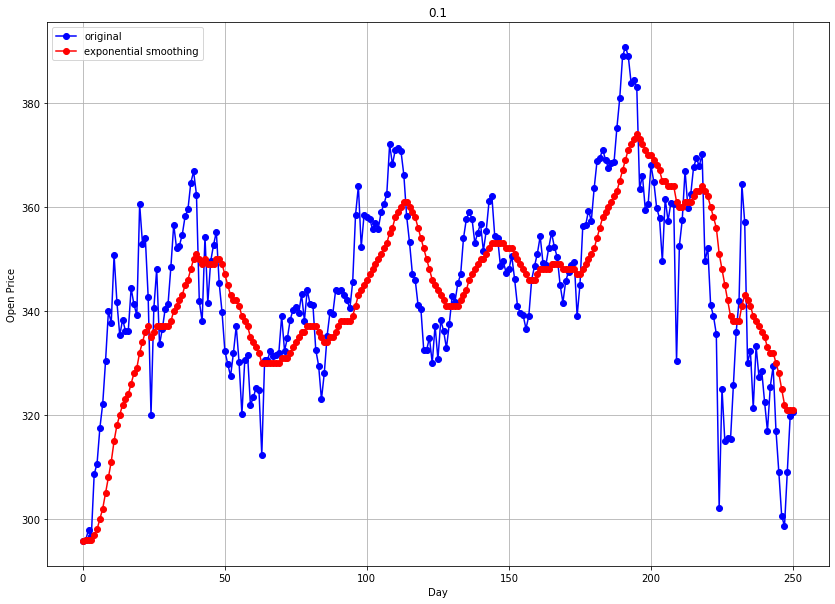

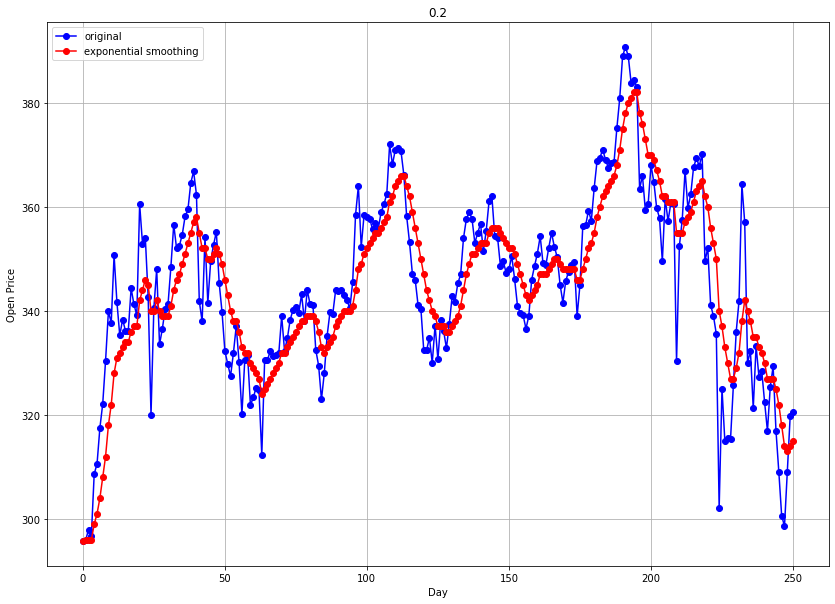

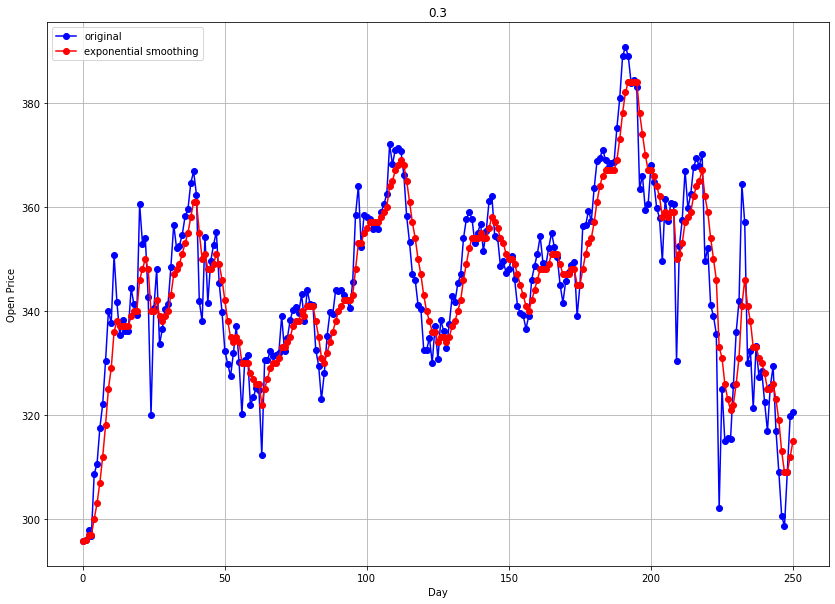

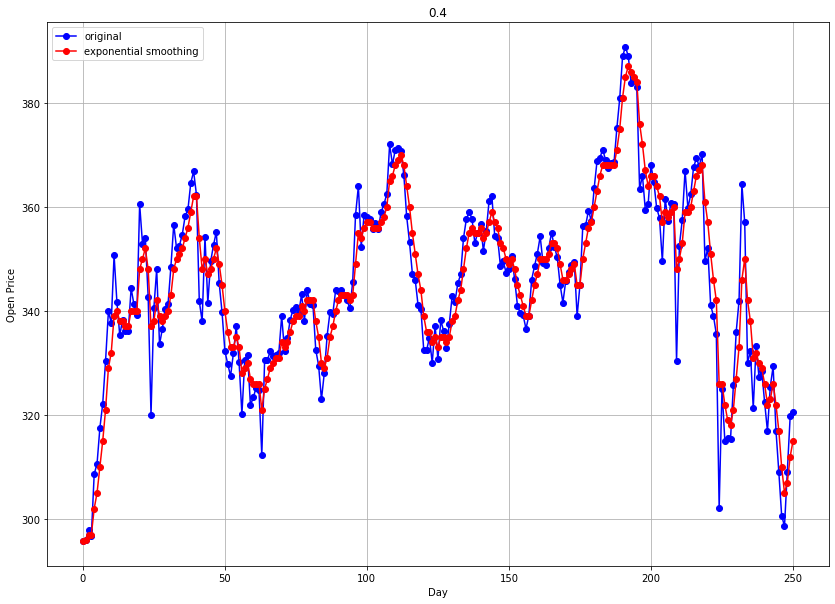

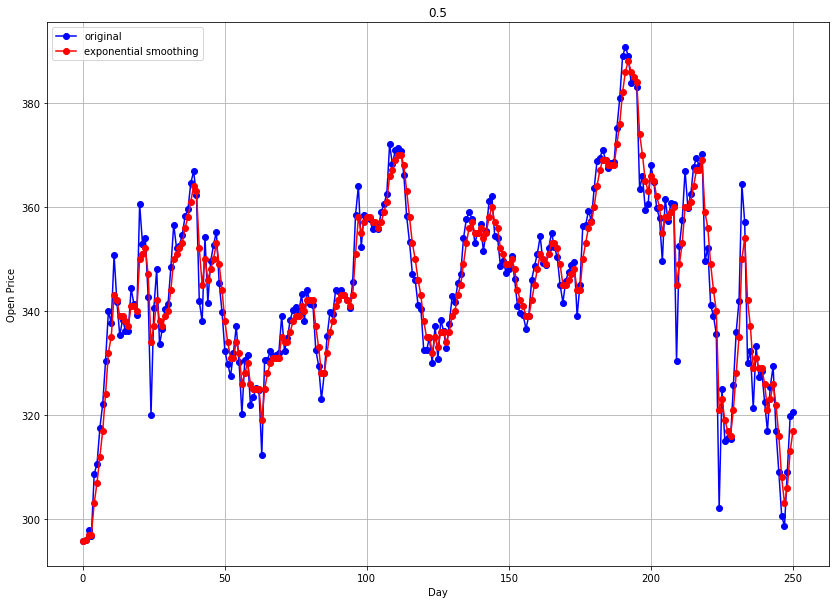

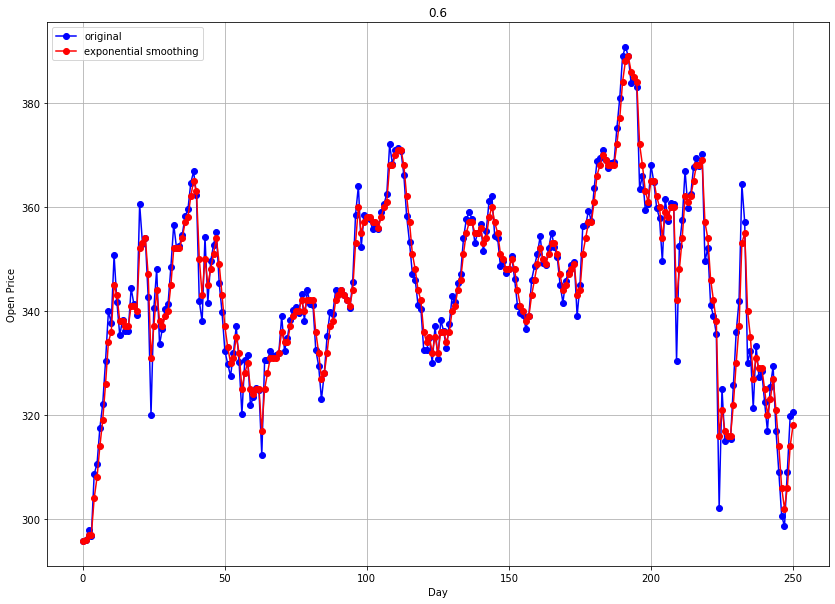

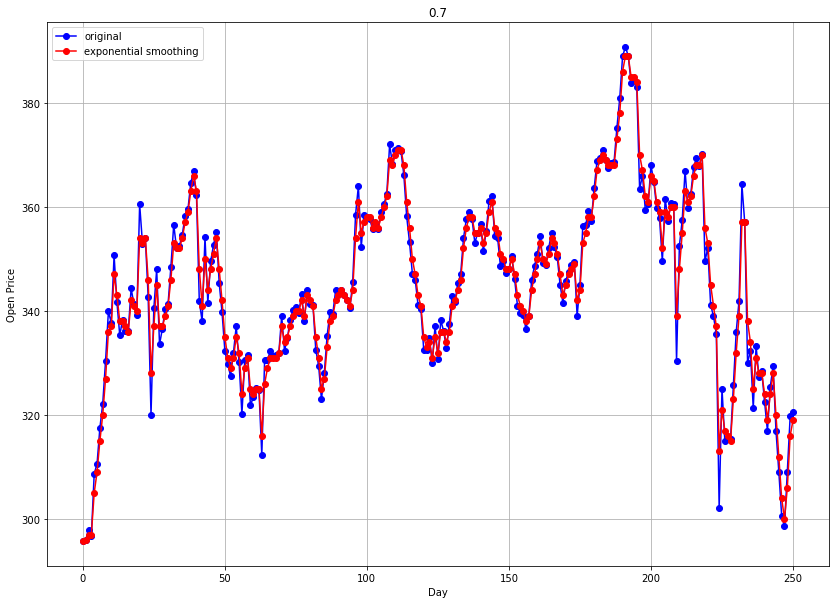

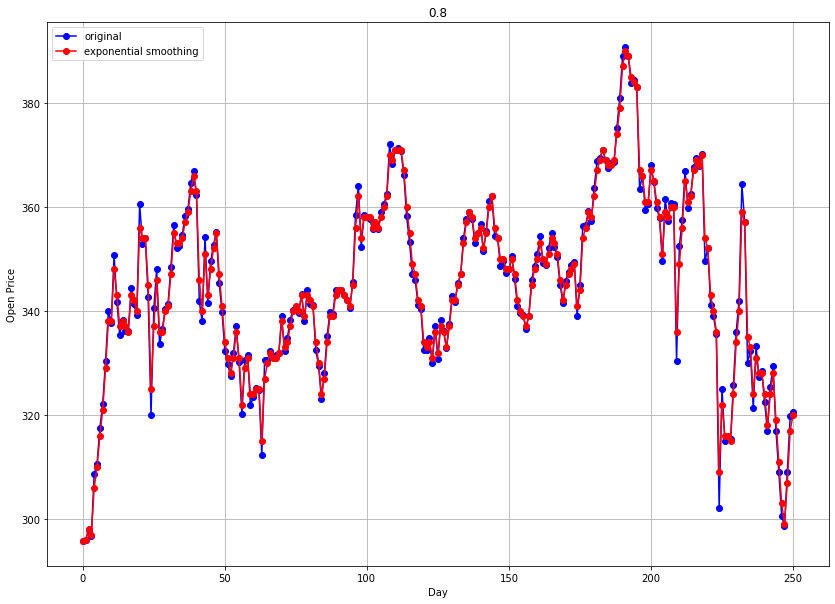

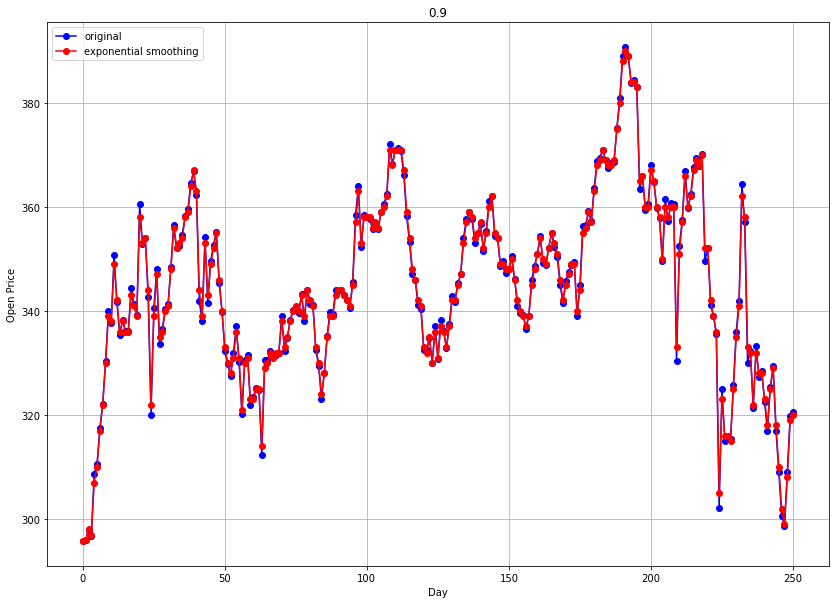

In [106]:
lenght = 251 #весь ряд значений
for a in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    smooth = exp_smooth(open_price, a, lenght)
    plt.figure(figsize=(14, 10))
    plt.plot(open_price.values, 'bo-', label = 'original')
    plt.plot(smooth, 'ro-', label = 'exponential smoothing')
    plt.xlabel('Day')
    plt.ylabel('Open Price')
    plt.legend(loc = 'upper left')
    plt.title(a)
    plt.grid(True)
    plt.show()

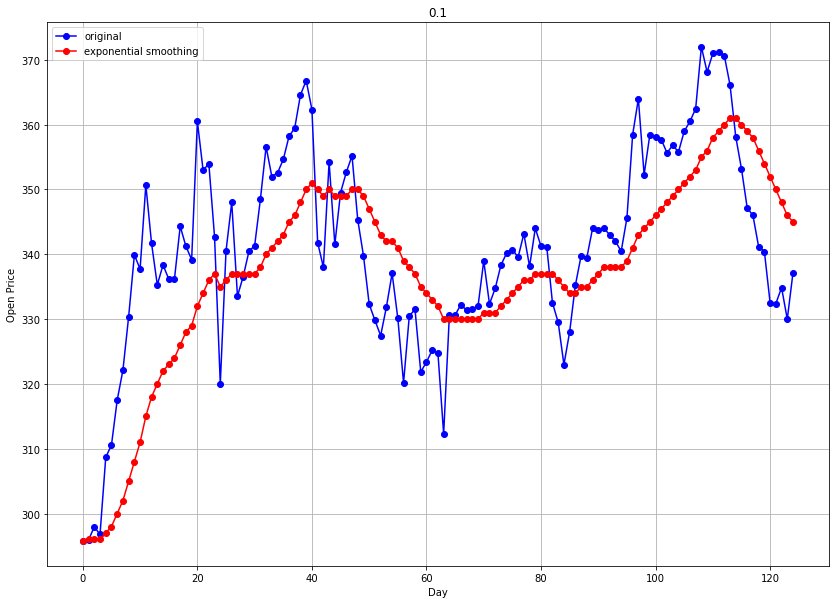

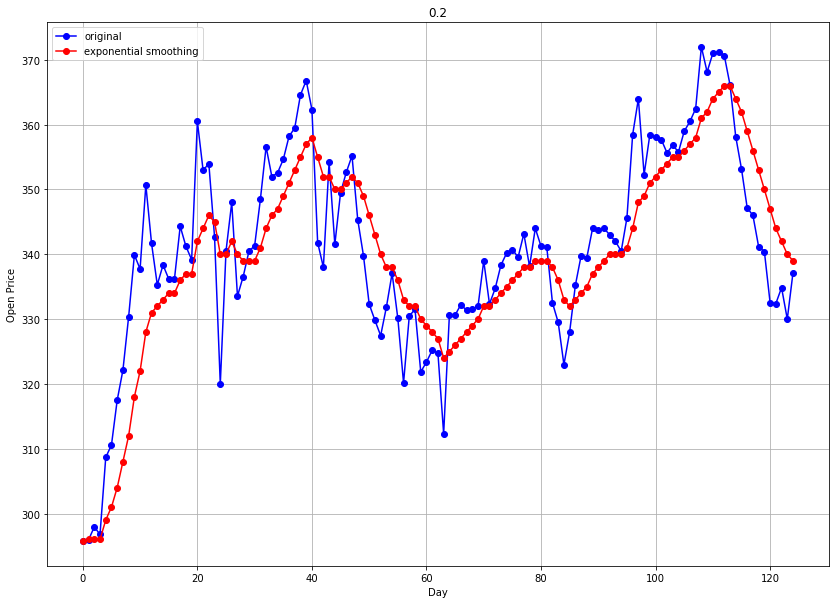

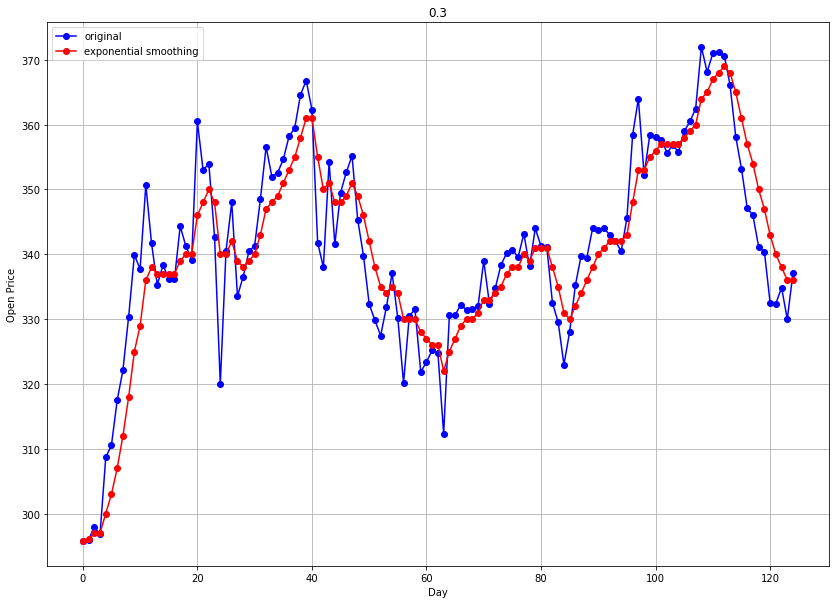

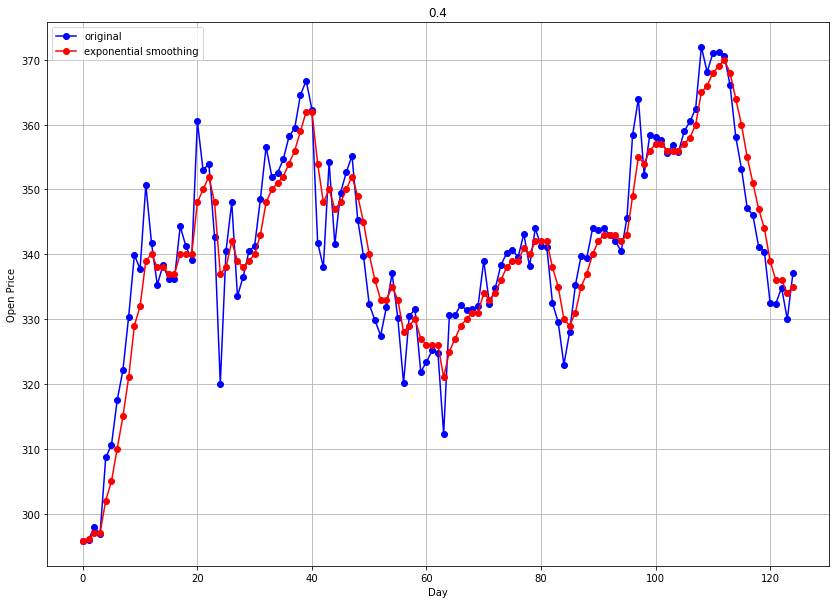

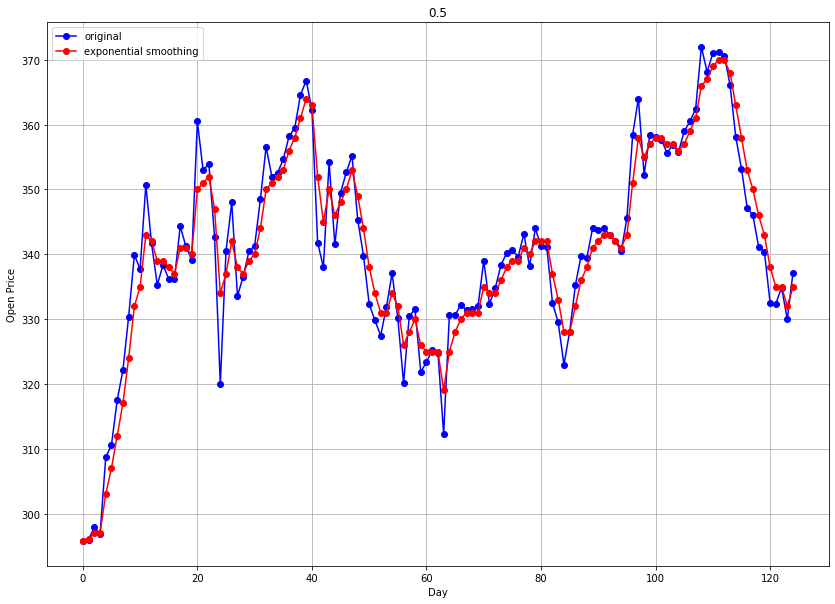

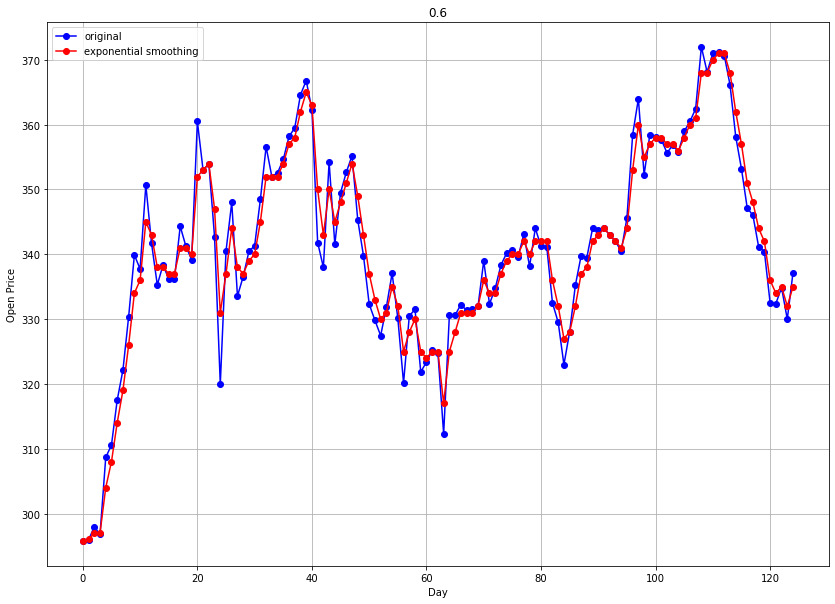

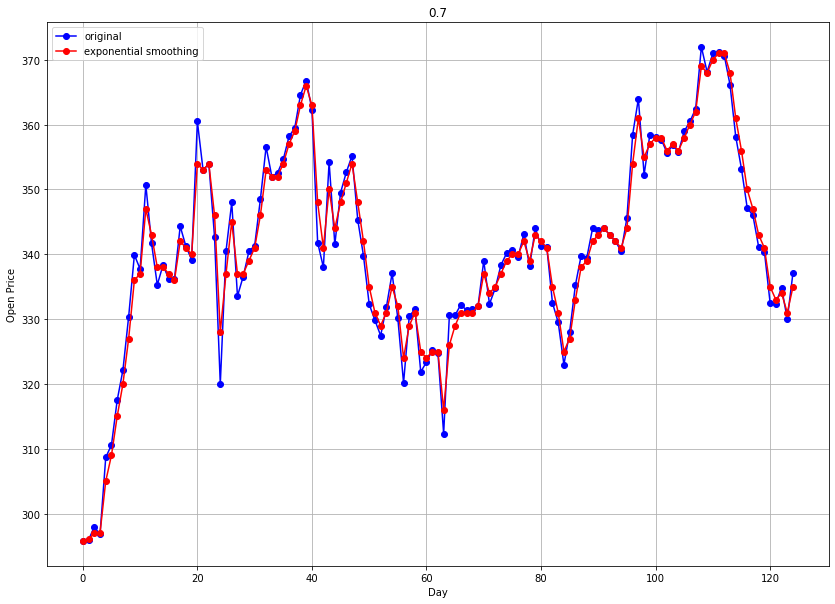

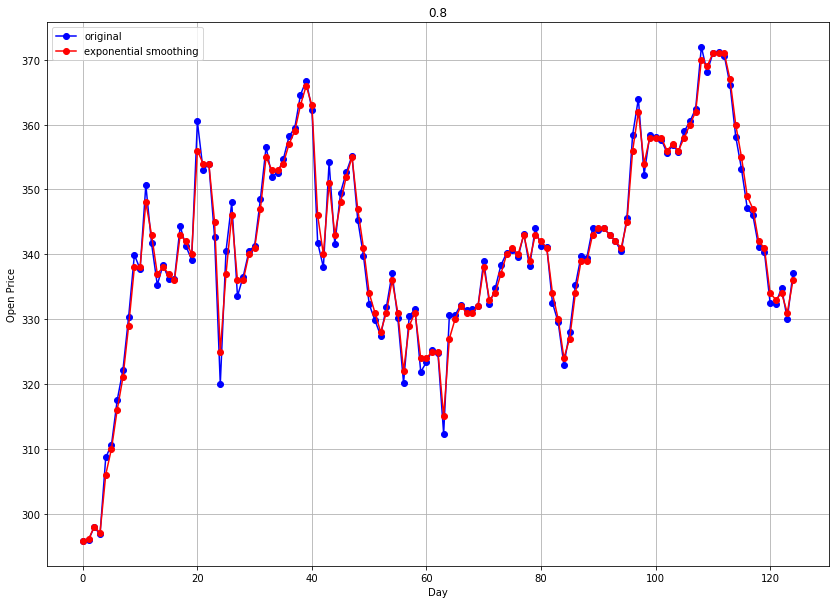

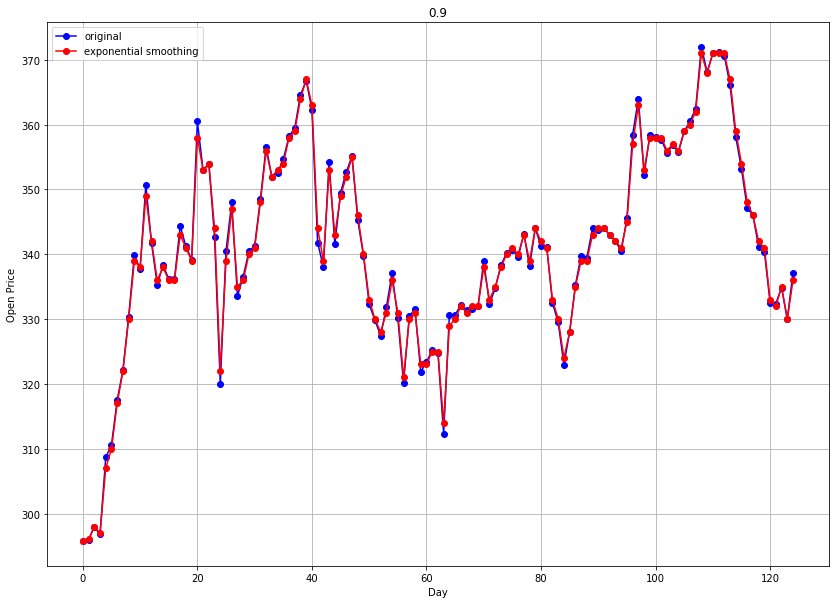

In [107]:
lenght = 125 #половина ряда значений
for a in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    smooth = exp_smooth(open_price, a, lenght)
    plt.figure(figsize=(14, 10))
    plt.plot(open_price.values[:125], 'bo-', label = 'original')
    plt.plot(smooth, 'ro-', label = 'exponential smoothing')
    plt.xlabel('Day')
    plt.ylabel('Open Price')
    plt.legend(loc = 'upper left')
    plt.title(a)
    plt.grid(True)
    plt.show()

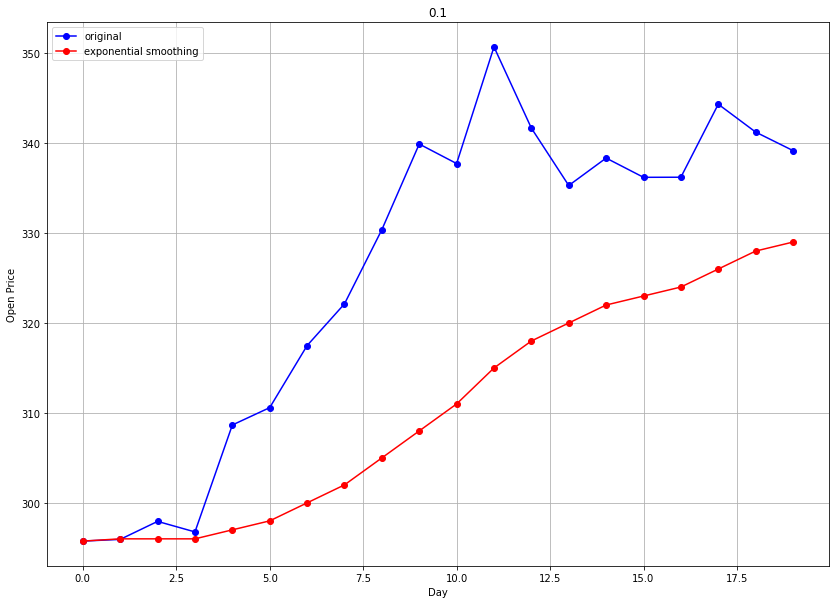

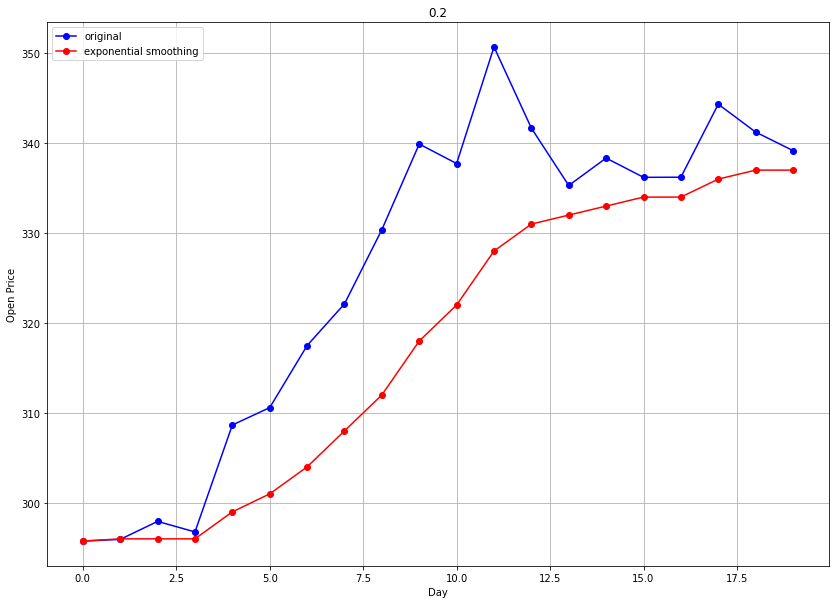

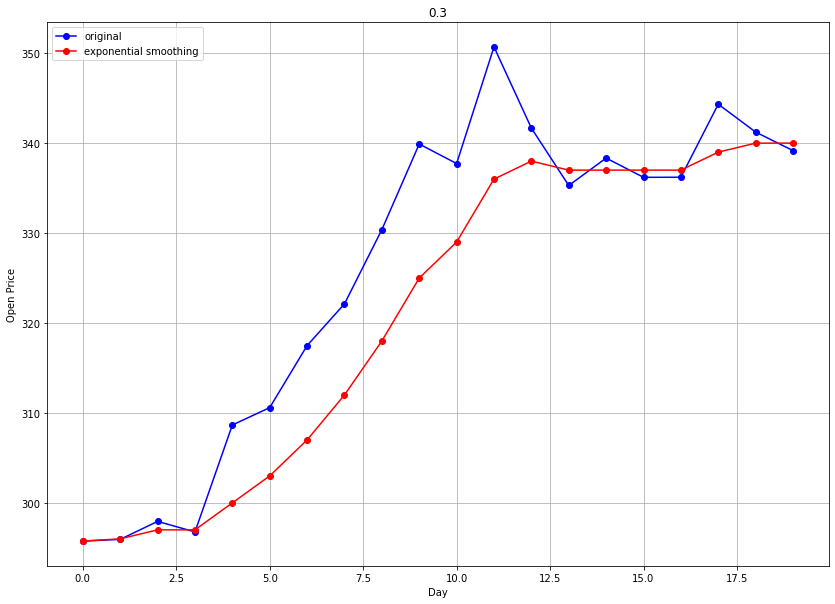

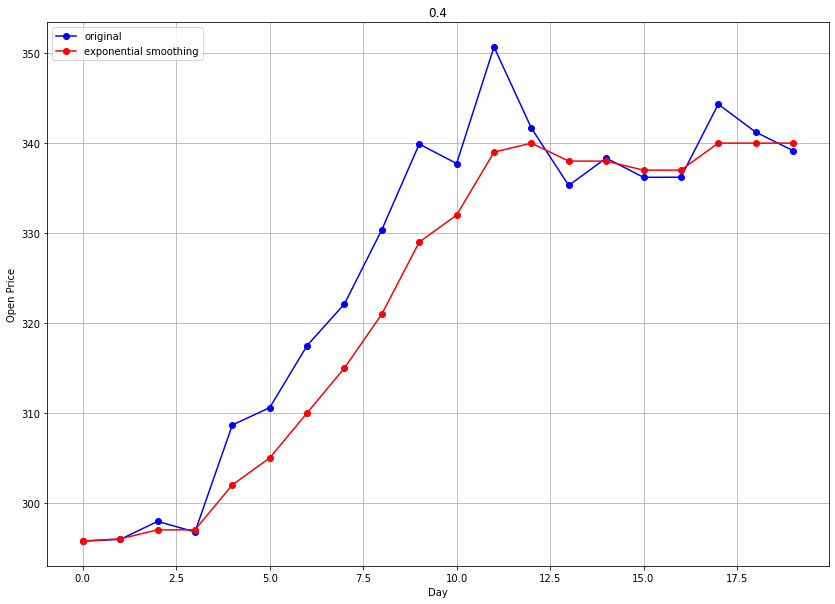

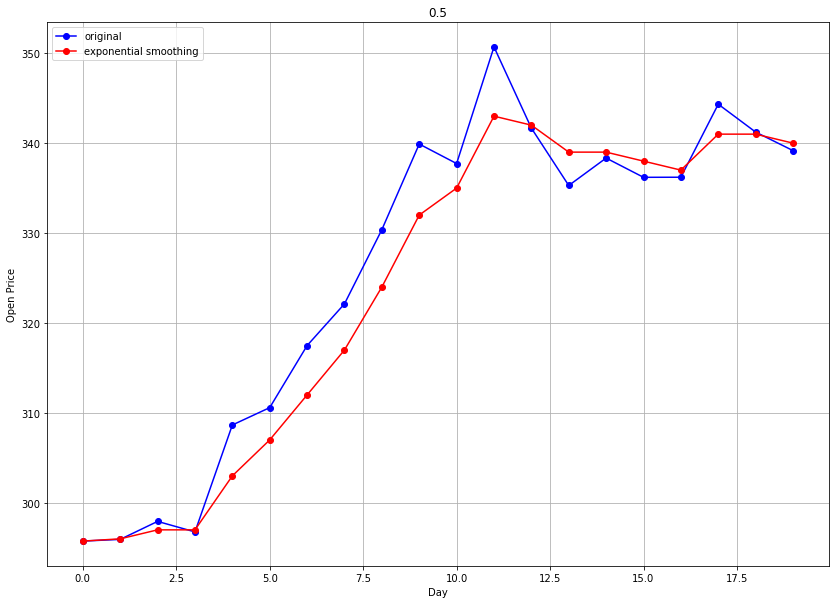

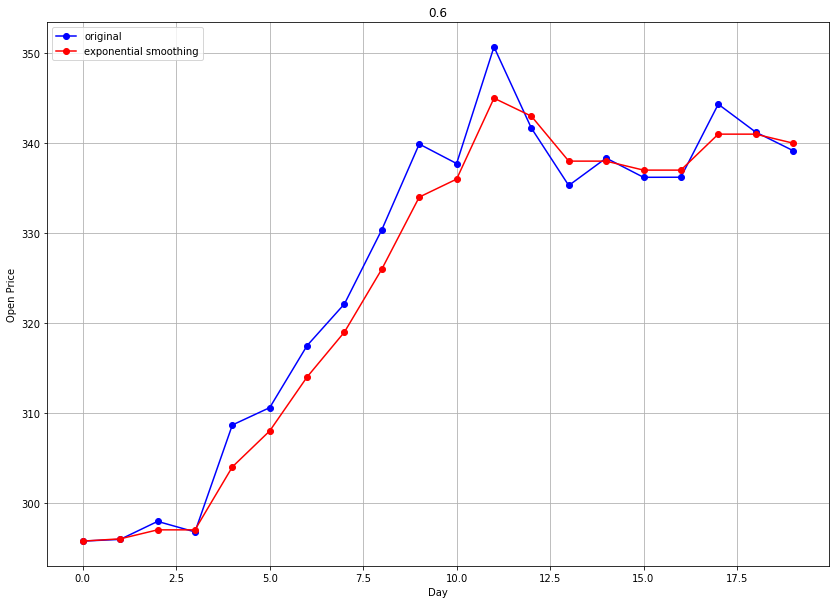

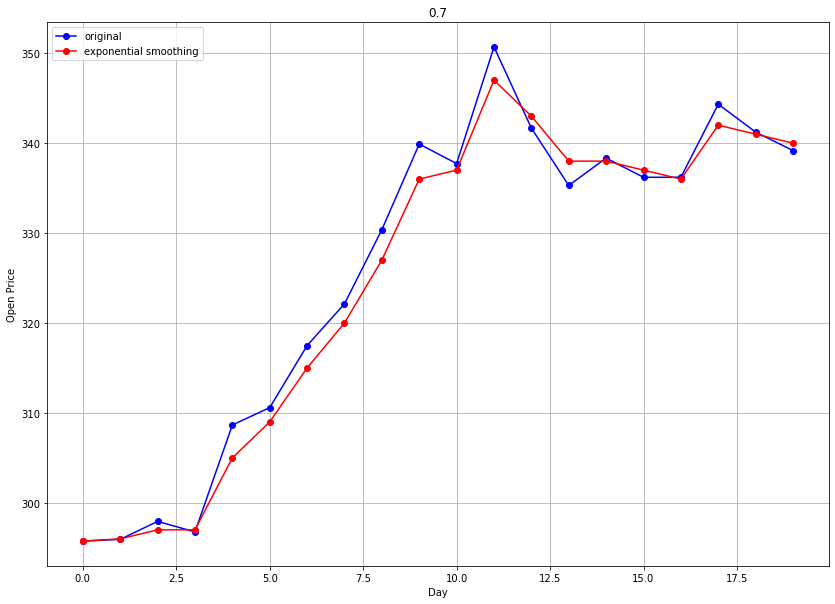

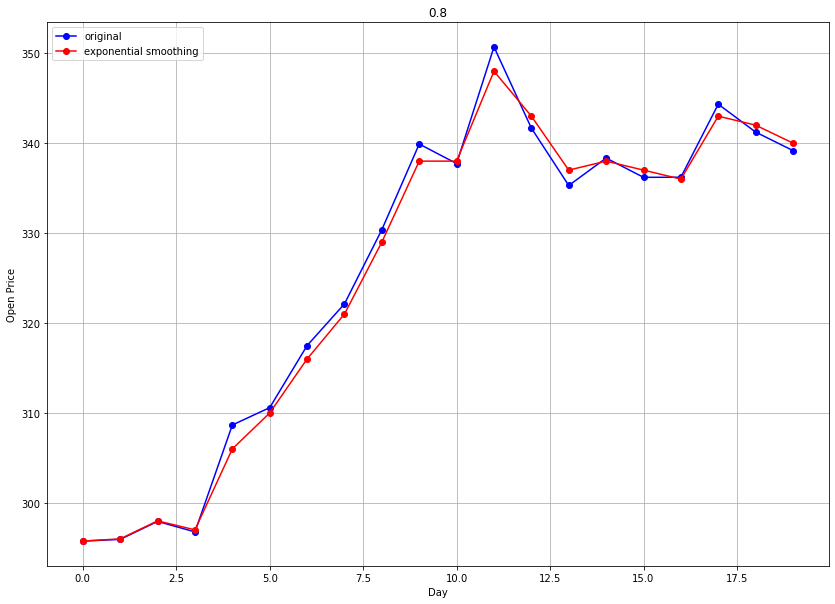

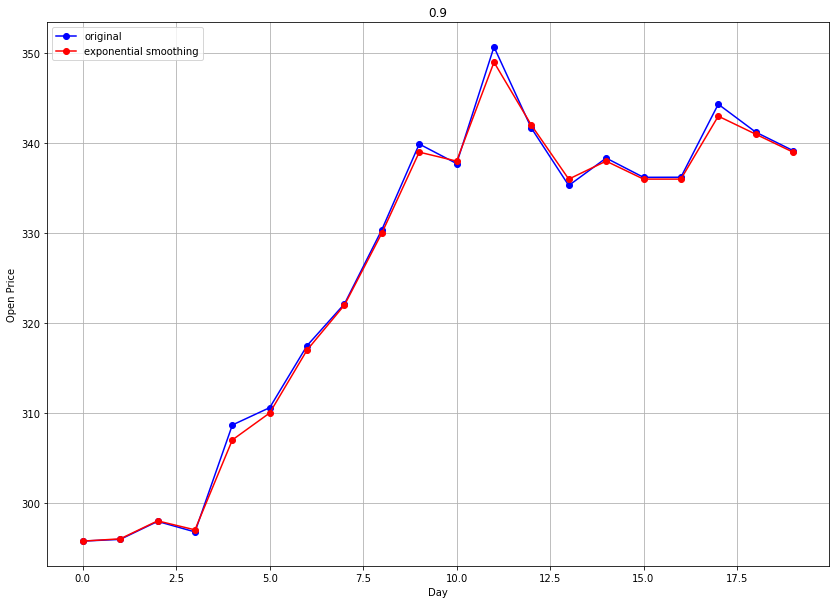

In [108]:
lenght = 20 #малая часть ряда значений
for a in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    smooth = exp_smooth(open_price, a, lenght)
    plt.figure(figsize=(14, 10))
    plt.plot(open_price.values[:20], 'bo-', label = 'original')
    plt.plot(smooth, 'ro-', label = 'exponential smoothing')
    plt.xlabel('Day')
    plt.ylabel('Open Price')
    plt.legend(loc = 'upper left')
    plt.title(a)
    plt.grid(True)
    plt.show()

Как видим во всех вариантах, чем большая $\alpha$ выбирается, тем меньше график сглаживается из-за возрастающих весов ближайших значений ряда, но тем больше пиков и выбросов остаются.

# Готовые модели

Выше была приведена ручная реализация метода. Кроме того, можно воспользоваться готовым методом из библиотеки statsmodels

In [118]:
from statsmodels.tsa.api import SimpleExpSmoothing

Он позволяет выбрать параметр $\alpha$ наиболее оптимально автоматически

In [142]:
open_price.index = range(len(open_price)) #без этого возникала ошибка с индексом, первая точка была в 1970 году
model = SimpleExpSmoothing(open_price)

C:\Users\Barca\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [143]:
fit1 = model.fit(smoothing_level = 0.3, optimized = False) #введем коэффициент сглаживания вручную
predicted1 = fit1.forecast(3) #горизонт прогнозирования, будет прямой линией

#а теперь автоматически
fit2 = model.fit()
predicted2 = fit2.forecast(3)

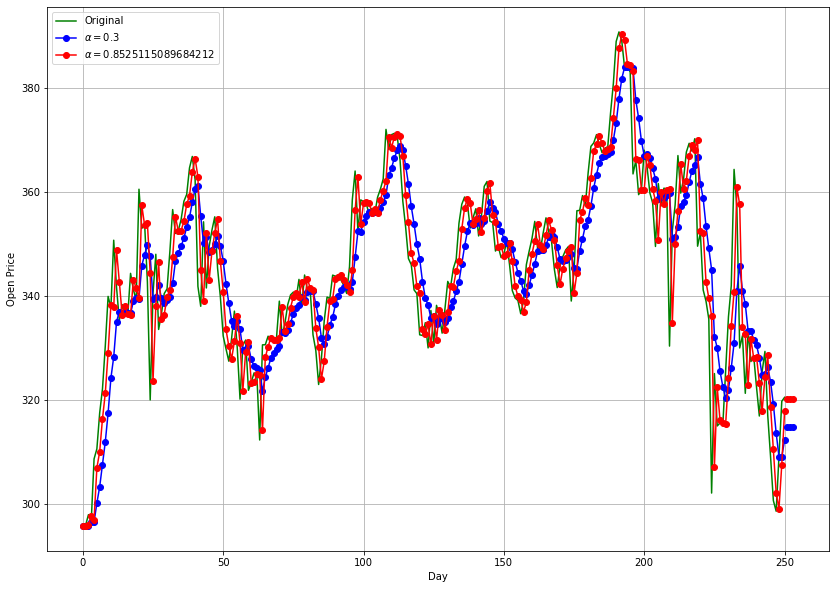

In [148]:
plt.figure(figsize=(14, 10))
plt.plot(open_price, 'g', label = 'Original')
plt.plot(fit1.fittedvalues, 'bo-', label = r'$\alpha=0.3$')
plt.plot(fit2.fittedvalues, 'ro-', label = r'$\alpha=%s$'%fit2.model.params['smoothing_level'])
plt.plot(predicted1, 'bo-')
plt.plot(predicted2, 'ro-')
plt.xlabel('Day')
plt.ylabel('Open Price')
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

Красный график с оптимальным $\alpha$ действительно точнее повторяет исходный ряд и предсказывает следующую точку